# Base

In [3]:
import gymnasium as gym
from tqdm import trange
import random
import numpy as np
from mdl import torch as mdl
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

def show_env(env):
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    clear_output(wait=True)

def show_envs(envs):
    imgs = envs.call('render')
    fig = plt.figure(1, figsize=(12, 8))
    # fig.set_figwidth(12)
    for i, img in enumerate(imgs):
        fig.add_subplot((len(imgs)+1)//2, 2, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f'env {i}')
    plt.show()
    clear_output(wait=True)

def print_q(Q, header='Q:'):
    asym = ['<', 'v', '>', '^']
    print(header)
    for i in range(Q.shape[0]):
        actions = Q[i]
        a = asym[np.argmax(actions)]
        q = np.max(actions)
        print(f'{q:4.2f}{a}', end=' ')
        if i % 4 == 3:
            print()

def random_run(env):
    state, _ = env.reset()
    terminated = truncated = False
    while not terminated and not truncated:
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, _ = env.step(action)
        show_env(env)

def actor_run(env, actor):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device='cuda').unsqueeze(0)
    terminated = truncated = False
    while not terminated and not truncated:
        with torch.inference_mode():
            action = actor(state)
        observation, reward, terminated, truncated, _ = env.step(action[0].tolist())
        state = torch.tensor(observation, dtype=torch.float32, device='cuda').unsqueeze(0)
        # print(f'terminated {terminated} truncated {truncated} reward {reward}')
        show_env(env)

def random_run_vec(envs):
    states, _ = envs.reset()
    done_once = np.zeros(envs.num_envs, dtype=bool)
    while not done_once.all():
        actions = envs.action_space.sample()
        next_states, rewards, terminated, truncated, _ = envs.step(actions)
        done_once |= terminated | truncated
        show_envs(envs)

def actor_run_vec(envs, actor):
    state, _ = envs.reset()
    state = torch.tensor(state, dtype=torch.float32, device='cuda')
    done_once = np.zeros(envs.num_envs, dtype=bool)
    while not done_once.all():
        with torch.inference_mode():
            action = actor(state)
        observation, reward, terminated, truncated, _ = envs.step(action.cpu().numpy())
        state = torch.tensor(observation, dtype=torch.float32, device='cuda')
        done_once |= terminated | truncated
        # print(f'terminated {terminated} truncated {truncated} reward {reward}')
        show_envs(envs)

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

TransitionWithMask = namedtuple('TransitionWithMask', ('state', 'action', 'next_state', 'reward', 'mask'))
class ReplayMemoryWithMask(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(TransitionWithMask(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

# FrozenLake

iter: 0
0.00< 0.00< 0.00< 0.00< 
0.00< 0.00< 0.00< 0.00< 
0.00< 0.00< 0.00< 0.00< 
0.00< 0.00< 0.00< 0.00< 
iter: 100
0.00< 0.00< 0.00< 0.00< 
0.00< 0.00< 0.00< 0.00< 
0.00< 0.00< 0.00< 0.00< 
0.00< 0.00< 0.00< 0.00< 
iter: 200
0.62> 0.65> 0.69v 0.65< 
0.53^ 0.00< 0.80v 0.00< 
0.00< 0.66> 0.93v 0.00< 
0.00< 0.00< 1.00> 0.00< 


error: XDG_RUNTIME_DIR not set in the environment.


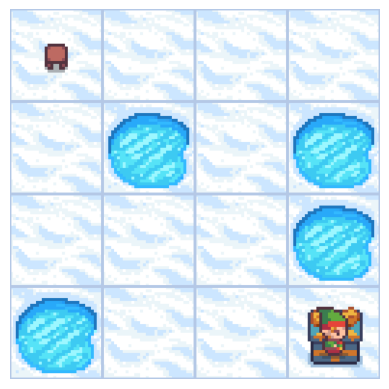

In [26]:
seed = random.randint(0, 1000000)
gamma = 0.95
num_iter = 300
alpha = 0.9
epsilon = 0.9
random.seed(seed)
np.random.seed(seed)
reward_count = 0

def e_greedy(env, Q, s, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[s])

env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="rgb_array")
env.action_space.seed(seed)
env.observation_space.seed(seed)
num_states = env.observation_space.n
num_actions = env.action_space.n
Q = np.zeros((num_states, num_actions))
for k in range(num_iter):
    state, _ = env.reset()
    done = False
    while not done:
        action = e_greedy(env, Q, state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        # update Q
        y = reward + gamma * Q[next_state, np.argmax(Q[next_state, :])]
        Q[state, action] += alpha * (y - Q[state, action])
        state = next_state
    if reward == 1:
        reward_count += 1
        # print(f'state {state} reward {reward} action {action} next_state {next_state}')
    if k % 100 == 0:
        print_q(Q, f'iter: {k}')
# print(f'reward_count: {reward_count}')

state, _ = env.reset()
done = False
while not done:
    action = e_greedy(env, Q, state, 0)
    next_state, reward, done, _, _ = env.step(action)
    state = next_state
show_env(env)

# CartPole

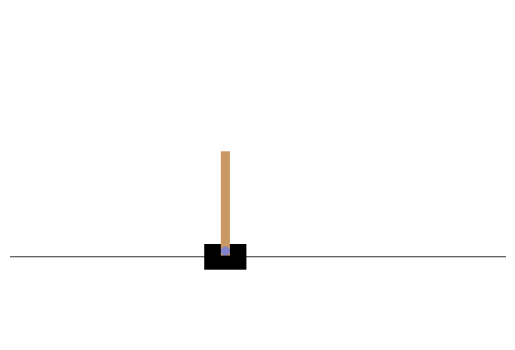

In [27]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
# state, _ = env.reset()
# done = False
# while not done:
#     action = env.action_space.sample()
#     next_state, reward, done, _, _ = env.step(action)
#     show_env(env)
# env.close()



class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer_1 = nn.Linear(n_observations, 128)
        self.layer_2 = nn.Linear(128, 128)
        self.layer_3 = nn.Linear(128, n_actions)
    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        return self.layer_3(x)

policy_net = DQN(env.observation_space.shape[0], env.action_space.n).to('cuda')
target_net = DQN(env.observation_space.shape[0], env.action_space.n).to('cuda')
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=1e-4, amsgrad=True)
memory = ReplayMemory(10000)
batch_size = 128
gamma = 0.99
TAU = 0.005

epsilon_start = 0.9
epsilon_end = 0.05
epsilon_decay = 1000
def get_epsilon(num_steps):
    return epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * num_steps / epsilon_decay)
num_steps = 0
def select_action(state, training=True):
    global num_steps
    sample = random.random()
    epsilon = get_epsilon(num_steps)
    num_steps += 1
    if not training or sample > epsilon:
        with torch.no_grad():
            action = policy_net(state).max(1).indices.view(1, 1)
    else:
        action = torch.tensor([[env.action_space.sample()]], device='cuda')
    return action

for i_episode in range(600):
    state, _ = env.reset()
    # state (1, 4)
    state = torch.tensor(state, dtype=torch.float32, device='cuda').unsqueeze(0)
    for t in count():
        # action (1, 1)
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        # reward (1)
        reward = torch.tensor([reward], device='cuda')
        done = terminated or truncated
        # next_state (1, 4)
        next_state = None if done else torch.tensor(observation, dtype=torch.float32, device='cuda').unsqueeze(0)
        memory.push(state, action, next_state, reward)
        state = next_state
        # optimize model
        if len(memory) >= batch_size:
            sample = memory.sample(batch_size)
            batch = Transition(*zip(*sample))
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device='cuda')
            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
            # state_batch (128, 4)
            state_batch = torch.cat(batch.state)
            # action_batch (128, 1)
            action_batch = torch.cat(batch.action)
            # reward_batch (128)
            reward_batch = torch.cat(batch.reward)
            # state_action_values (128, 1)
            state_action_values = policy_net(state_batch).gather(1, action_batch)
            # next_state_values (128)
            next_state_values = torch.zeros(batch_size, device='cuda')
            with torch.no_grad():
                next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
            # expected_state_action_values (128)
            expected_state_action_values = (next_state_values * gamma) + reward_batch
            loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 100)
            optimizer.step()
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        if done:
            print(f'episode {i_episode} t {t} terminated({terminated}) truncated({truncated})') if i_episode % 10 == 0 else None
            break
# run the model            
state, _ = env.reset()
state = torch.tensor(state, dtype=torch.float32, device='cuda').unsqueeze(0)
for t in count():
    action = select_action(state, training=False)
    observation, reward, terminated, truncated, _ = env.step(action.item())
    state = torch.tensor(observation, dtype=torch.float32, device='cuda').unsqueeze(0)
    show_env(env)
    if terminated or truncated:
        break

# Bipdal Walker

In [27]:
num_envs = 4
num_episodes = 4000
show_envs_freq = 0
batch_size = 128
gamma = 0.99 # gamma通常取[0.95, 0.99]
tau = 0.005  # tau通常取[0.005, 0.01]
actor_update_freq = 2
hidden_size = 128
hidden_multiplier = 3

env = gym.make('BipedalWalker-v3', render_mode="rgb_array")
envs = gym.make_vec('BipedalWalker-v3', render_mode="rgb_array", num_envs=num_envs, vectorization_mode='sync')
# random_run(env)
# random_run_vec(envs)

class Actor(nn.Module):
    def __init__(self, n_observations, n_actions):
        super().__init__()
        self.layer_1 = nn.Linear(n_observations, hidden_size * hidden_multiplier)
        self.layer_2 = nn.Linear(hidden_size * hidden_multiplier, hidden_size)
        self.layer_3 = nn.Linear(hidden_size, n_actions)
    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        return F.tanh(self.layer_3(x))

class Critic(nn.Module):
    def __init__(self, n_observations, n_actions):
        super().__init__()
        self.layer_1 = nn.Linear(n_observations + n_actions, hidden_size * hidden_multiplier)
        self.layer_2 = nn.Linear(hidden_size * hidden_multiplier, hidden_size)
        self.layer_3 = nn.Linear(hidden_size, 1)
    def forward(self, s, a):
        x = torch.cat((s, a), 1)
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        return self.layer_3(x).squeeze(-1)

class TD3:
    def __init__(self, n_observations, n_actions, device='cuda'):
        super().__init__()
        self.actor = Actor(n_observations, n_actions).to(device)
        self.critic_1 = Critic(n_observations, n_actions).to(device)
        self.critic_2 = Critic(n_observations, n_actions).to(device)
        self.target_actor = Actor(n_observations, n_actions).to(device)
        self.target_critic_1 = Critic(n_observations, n_actions).to(device)
        self.target_critic_2 = Critic(n_observations, n_actions).to(device)
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.optim_actor = optim.AdamW(self.actor.parameters(), lr=1e-4, amsgrad=True)
        self.optim_critic_1 = optim.AdamW(self.critic_1.parameters(), lr=1e-4, amsgrad=True)
        self.optim_critic_2 = optim.AdamW(self.critic_2.parameters(), lr=1e-4, amsgrad=True)

td3 = TD3(env.observation_space.shape[0], env.action_space.shape[0])
memory = ReplayMemoryWithMask(10000)

def select_action(state, actor, noise_std=0.1, noise_clip=None, action_min=-1.0, action_max=1.0):
    with torch.no_grad():
        # 使用 Actor 网络输出动作
        action = actor(state)
        # 添加探索噪声
        noise = torch.randn_like(action, device=action.device) * noise_std
        if noise_clip is not None:
            noise = noise.clamp(-noise_clip, noise_clip)
        action = action + noise
        # 将动作限制在环境允许的范围内
        action = action.clamp(action_min, action_max)
    return action

critic_update_count = 0

i_episode = 0
total_reward = np.zeros(num_envs)
steps = np.zeros(num_envs, dtype=int)
state, _ = envs.reset()
# state (num_envs, 24)
state = torch.tensor(state, dtype=torch.float32, device='cuda')
assert state.shape == (num_envs, 24)
for t in count():
    # action (num_envs, 4)
    action = select_action(state, td3.actor).cpu()
    assert action.shape == (num_envs, 4)
    observation, reward, terminated, truncated, _ = envs.step(action.numpy())
    total_reward += reward
    steps += 1
    # reward (num_envs)
    reward = torch.tensor(reward, device='cpu')
    assert reward.shape == (num_envs,)
    # done (num_envs)
    done = torch.tensor(np.logical_or(terminated, truncated), device='cpu')
    assert done.shape == (num_envs,)
    # next_state (num_envs, 24)
    next_state = torch.tensor(observation, dtype=torch.float32, device='cuda')
    assert next_state.shape == (num_envs, 24)
    # record the transition
    memory.push(state, action, next_state, reward, done)
    state = next_state
    # optimize model
    if len(memory) >= batch_size:
        sample = memory.sample(batch_size)
        batch = TransitionWithMask(*zip(*sample))
        done_batch = torch.cat(batch.mask).to('cuda')
        non_final_mask = ~done_batch
        next_state_batch = torch.cat(batch.next_state).to('cuda')
        non_final_next_states = next_state_batch[non_final_mask]
        # state_batch (batch_size*num_envs, 24)
        state_batch = torch.cat(batch.state).to('cuda')
        # action_batch (batch_size*num_envs, 4)
        action_batch = torch.cat(batch.action).to('cuda')
        # reward_batch (batch_size*num_envs)
        reward_batch = torch.cat(batch.reward).to('cuda')
        # state_action_values (batch_size*num_envs, 1)
        td3.critic_1.train()
        state_action_values_1 = td3.critic_1(state_batch, action_batch)
        state_action_values_2 = td3.critic_2(state_batch, action_batch)
        # next_state_values (batch_size*num_envs)
        next_state_values = torch.zeros(batch_size * num_envs, device='cuda')
        with torch.no_grad():
            non_final_next_actions = select_action(non_final_next_states, td3.target_actor, noise_std=0.1, noise_clip=0.5)
            next_state_values[non_final_mask] = torch.min(td3.target_critic_1(non_final_next_states, non_final_next_actions),
                                                        td3.target_critic_2(non_final_next_states, non_final_next_actions))
            # expected_state_action_values (batch_size*num_envs)
            expected_state_action_values = (next_state_values * gamma) + reward_batch
        loss_1 = F.smooth_l1_loss(state_action_values_1, expected_state_action_values)
        loss_2 = F.smooth_l1_loss(state_action_values_2, expected_state_action_values)
        td3.optim_critic_1.zero_grad()
        td3.optim_critic_2.zero_grad()
        loss_1.backward()
        loss_2.backward()
        torch.nn.utils.clip_grad_norm_(td3.critic_1.parameters(), 100)
        torch.nn.utils.clip_grad_norm_(td3.critic_2.parameters(), 100)
        td3.optim_critic_1.step()
        td3.optim_critic_2.step()
        # Soft update of the target critic network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        critic_1_state_dict = td3.critic_1.state_dict()
        critic_2_state_dict = td3.critic_2.state_dict()
        target_critic_1_state_dict = td3.target_critic_1.state_dict()
        target_critic_2_state_dict = td3.target_critic_2.state_dict()
        for key in critic_1_state_dict:
            target_critic_1_state_dict[key] = critic_1_state_dict[key]*tau + target_critic_1_state_dict[key]*(1-tau)
            target_critic_2_state_dict[key] = critic_2_state_dict[key]*tau + target_critic_2_state_dict[key]*(1-tau)
        td3.target_critic_1.load_state_dict(target_critic_1_state_dict)
        td3.target_critic_2.load_state_dict(target_critic_2_state_dict)
        critic_update_count += 1
        # optimize actor
        if critic_update_count % actor_update_freq == 0:
            loss = -td3.critic_1(state_batch, td3.actor(state_batch)).mean()
            td3.optim_critic_1.zero_grad()
            td3.optim_actor.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(td3.actor.parameters(), 100)
            td3.optim_actor.step()
            # Soft update of the target actor network's weights
            target_actor_state_dict = td3.target_actor.state_dict()
            actor_state_dict = td3.actor.state_dict()
            for key in actor_state_dict:
                target_actor_state_dict[key] = actor_state_dict[key]*tau + target_actor_state_dict[key]*(1-tau)
            td3.target_actor.load_state_dict(target_actor_state_dict)
    # an episode done
    for i, (terminated, truncated) in enumerate(zip(terminated, truncated)):
        if terminated or truncated:
            print(f't {t} episode {i_episode} terminated({terminated}) truncated({truncated}) total_reward {total_reward[i]} steps {steps[i]}') if i_episode % 10 == 0 else None
            i_episode += 1
            total_reward[i] = 0
            steps[i] = 0
    # show the env
    if show_envs_freq > 0 and i_episode % show_envs_freq == 0:
        show_envs(envs)
    if i_episode >= num_episodes or total_reward.max() >= 320:
        break


t 98 episode 0 terminated(True) truncated(False) total_reward -93.1401370488042 steps 99
t 339 episode 10 terminated(True) truncated(False) total_reward -106.4995169411134 steps 136
t 5047 episode 20 terminated(False) truncated(True) total_reward -54.594031844674284 steps 1601
t 8253 episode 30 terminated(False) truncated(True) total_reward -26.455922482688084 steps 1601
t 10535 episode 40 terminated(True) truncated(False) total_reward -134.84421510847005 steps 1086
t 13148 episode 50 terminated(True) truncated(False) total_reward -97.45782170610688 steps 98
t 16086 episode 60 terminated(False) truncated(True) total_reward -54.86394832228629 steps 1601
t 19651 episode 70 terminated(False) truncated(True) total_reward -33.759143426876534 steps 1601
t 23725 episode 80 terminated(False) truncated(True) total_reward -16.553063382663378 steps 1601
t 27293 episode 90 terminated(False) truncated(True) total_reward -43.86568408923315 steps 1601
t 31080 episode 100 terminated(False) truncated(T

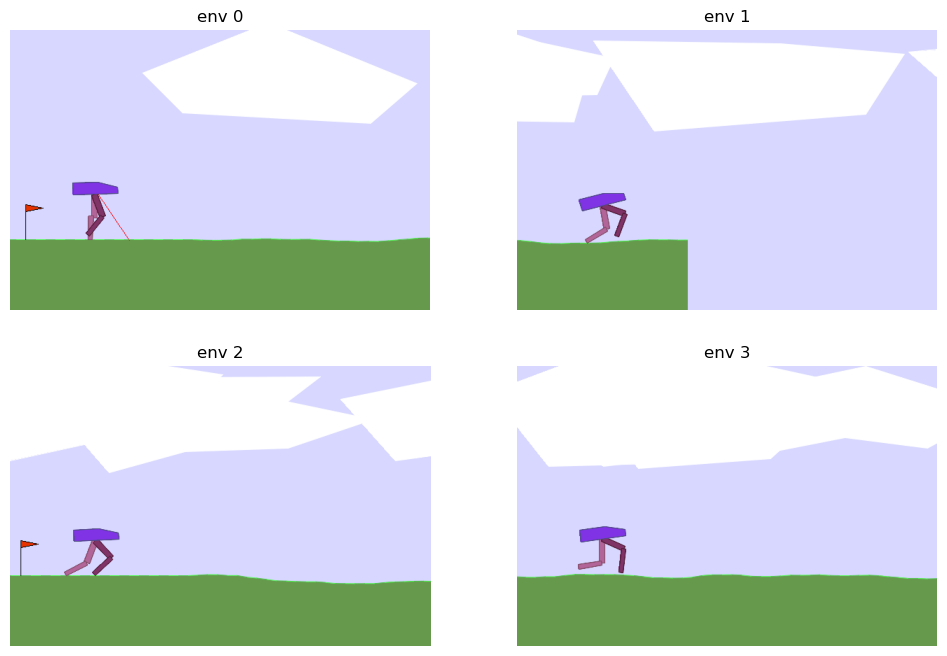

In [30]:
# torch.save(td3.actor.state_dict(), '/home/data/rl/bipedal/td3_actor.pth')
# torch.save(td3.critic_1.state_dict(), '/home/data/rl/bipedal/td3_critic_1.pth')
# torch.save(td3.critic_2.state_dict(), '/home/data/rl/bipedal/td3_critic_2.pth')

# run the model            
envs = gym.make_vec('BipedalWalker-v3', render_mode="rgb_array", num_envs=4, vectorization_mode='sync')
actor_run_vec(envs, td3.actor)
